In [116]:
# Imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
%matplotlib inline
from wrf import to_np
import metpy.calc as mpcalc
from metpy.units import units
from numba import jit
import warnings
from skimage.morphology import binary_dilation, disk, remove_small_objects
from skimage.measure import regionprops
from scipy.ndimage.measurements import label
import sys

/tmp/ipykernel_2127841/3180878429.py:17: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [121]:
# Create filepaths for datasets
filepath1km = ('/chinook2/stluthi/cm1_output/single_bubble/no_wind//1kmdx_50vlvls/cm1out_1kmdx_50vlvls.nc')

# Open data with xarray
cm1_1km = xr.open_dataset(filepath1km)
cm1_1km

<xarray.Dataset>
Dimensions:   (one: 1, time: 17, xh: 900, xf: 901, yh: 900, yf: 901, zh: 50,
               zf: 51)
Coordinates:
  * time      (time) timedelta64[ns] 00:00:00 00:30:00 ... 07:30:00 08:00:00
  * xh        (xh) float32 0.5 1.5 2.5 3.5 4.5 ... 895.5 896.5 897.5 898.5 899.5
  * xf        (xf) float32 0.0 1.0 2.0 3.0 4.0 ... 896.0 897.0 898.0 899.0 900.0
  * yh        (yh) float32 0.5 1.5 2.5 3.5 4.5 ... 895.5 896.5 897.5 898.5 899.5
  * yf        (yf) float32 0.0 1.0 2.0 3.0 4.0 ... 896.0 897.0 898.0 899.0 900.0
  * zh        (zh) float32 0.05 0.15 0.25 0.35 0.45 ... 18.25 18.75 19.25 19.75
  * zf        (zf) float32 0.0 0.1 0.2 0.3 0.4 0.5 ... 18.0 18.5 19.0 19.5 20.0
Dimensions without coordinates: one
Data variables: (12/98)
    ztop      (one) float32 ...
    rain      (time, yh, xh) float32 ...
    prate     (time, yh, xh) float32 ...
    sws       (time, yh, xh) float32 ...
    svs       (time, yh, xh) float32 ...
    sps       (time, yh, xh) float32 ...
    ...        ...
    kmh       (time, zf, yh, xh) float32 ...
    khh       (time, zf, yh, xh) float32 ...
    exch_h    (time, zf, yh, xh) float32 ...
    exch_m    (time, zf, yh, xh) float32 ...
    tke_myj   (time, zf, yh, xh) float32 ...
    el_myj    (time, zf, yh, xh) float32 ...
Attributes: (12/71)
    CM1 version:    cm1r20.2
    Conventions:    CF-1.7
    missing_value:  -999999.9
    x_units:        km
    x_label:        x
    y_units:        km
    ...             ...
    cgt1:           1.875
    cgt2:           -1.25
    cgt3:           0.375
    dgt1:           2.0
    dgt2:           -3.0
    dgt3:           1.0

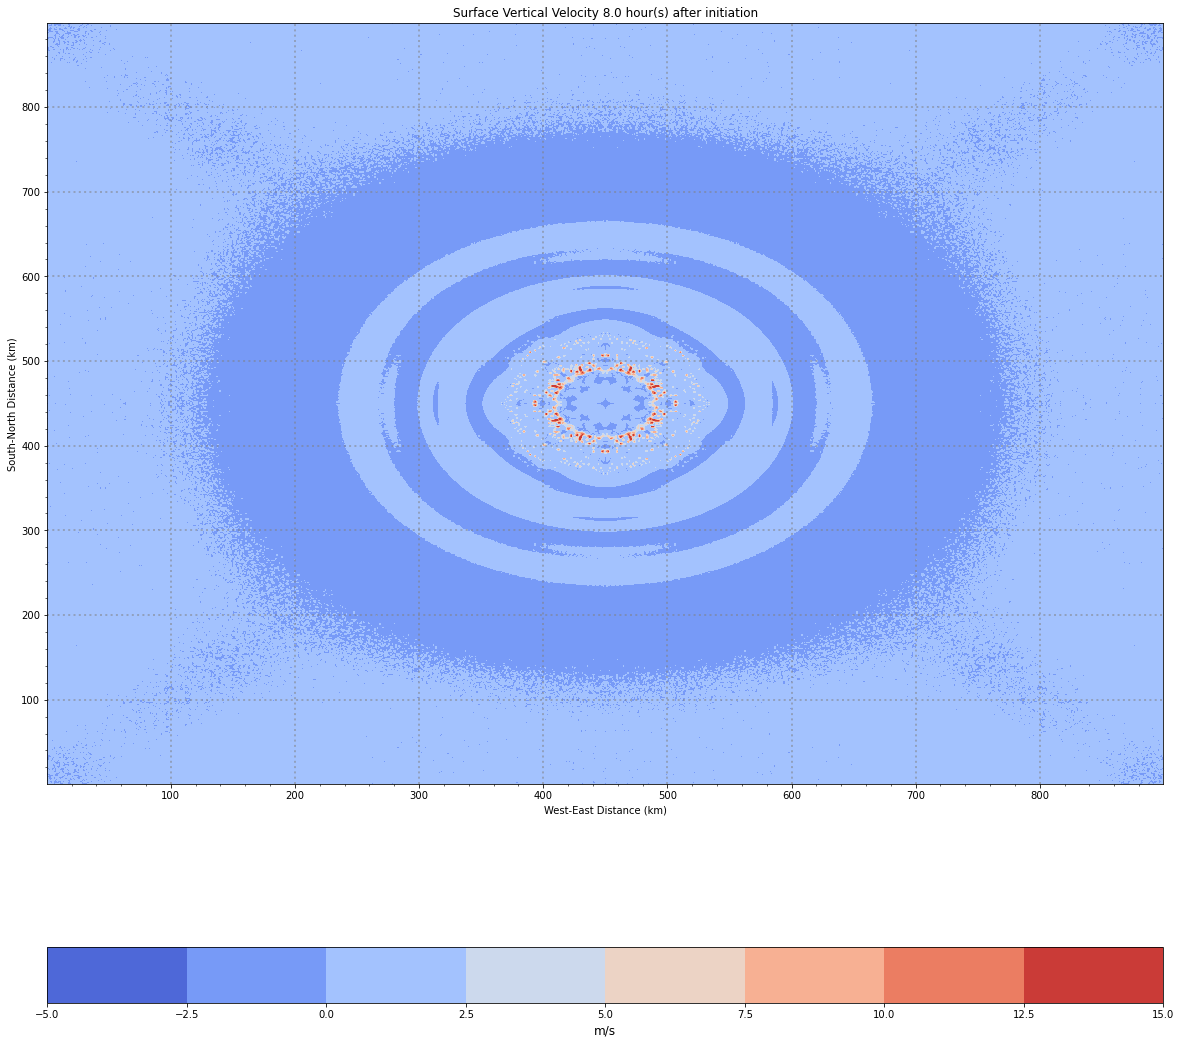

In [122]:
vertVelo = cm1_1km['w']
zf = cm1_1km['zf']
#zf

vertVeloLL = vertVelo[10, 11:18, :, :]
vertVeloLLComp = vertVeloLL.max(dim='zf')
vertVeloLLCoord = vertVeloLL.argmax(dim='zf')
#vertVeloLLCoord


fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(1, 1, 1)

vvLLCompCF = ax1.contourf(vertVeloLLComp.metpy.x, vertVeloLLComp.metpy.y, vertVeloLLComp, cmap='coolwarm')
cb = fig.colorbar(vvLLCompCF, ax=ax1, orientation='horizontal')
cb.set_label('m/s', fontsize=12)
ax1.set_title('Surface Vertical Velocity ' + str(hour * 0.5) + ' hour(s) after initiation')
ax1.set_xlabel('West-East Distance (km)')
ax1.set_ylabel('South-North Distance (km)')
ax1.minorticks_on()
ax1.grid(which='major', color='gray', alpha=0.5, linestyle='dotted', linewidth=2.)

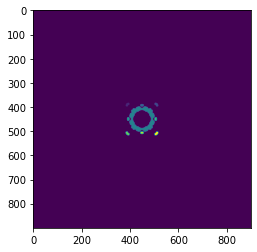

In [123]:
threshVertVeloLL = vertVeloLLComp > 9

res = '1km'
buffer = '5km'
buffer_px = int((units(buffer) / units(res)).m)
bufferedVV = binary_dilation(threshVertVeloLL.values, footprint=disk(buffer_px))

labeled_image, _ = label(bufferedVV, np.ones((3,3), dtype=int))
remove_small_objects(labeled_image, min_size=buffer_px * 3, connectivity=2)

subsets_VV = []
for region in regionprops(labeled_image):
    subsets_VV.append(vertVeloLLComp.isel(
        yh=slice(region.bbox[0], region.bbox[2]),
        xh=slice(region.bbox[1], region.bbox[3])
    ))
    
plt.imshow(labeled_image)

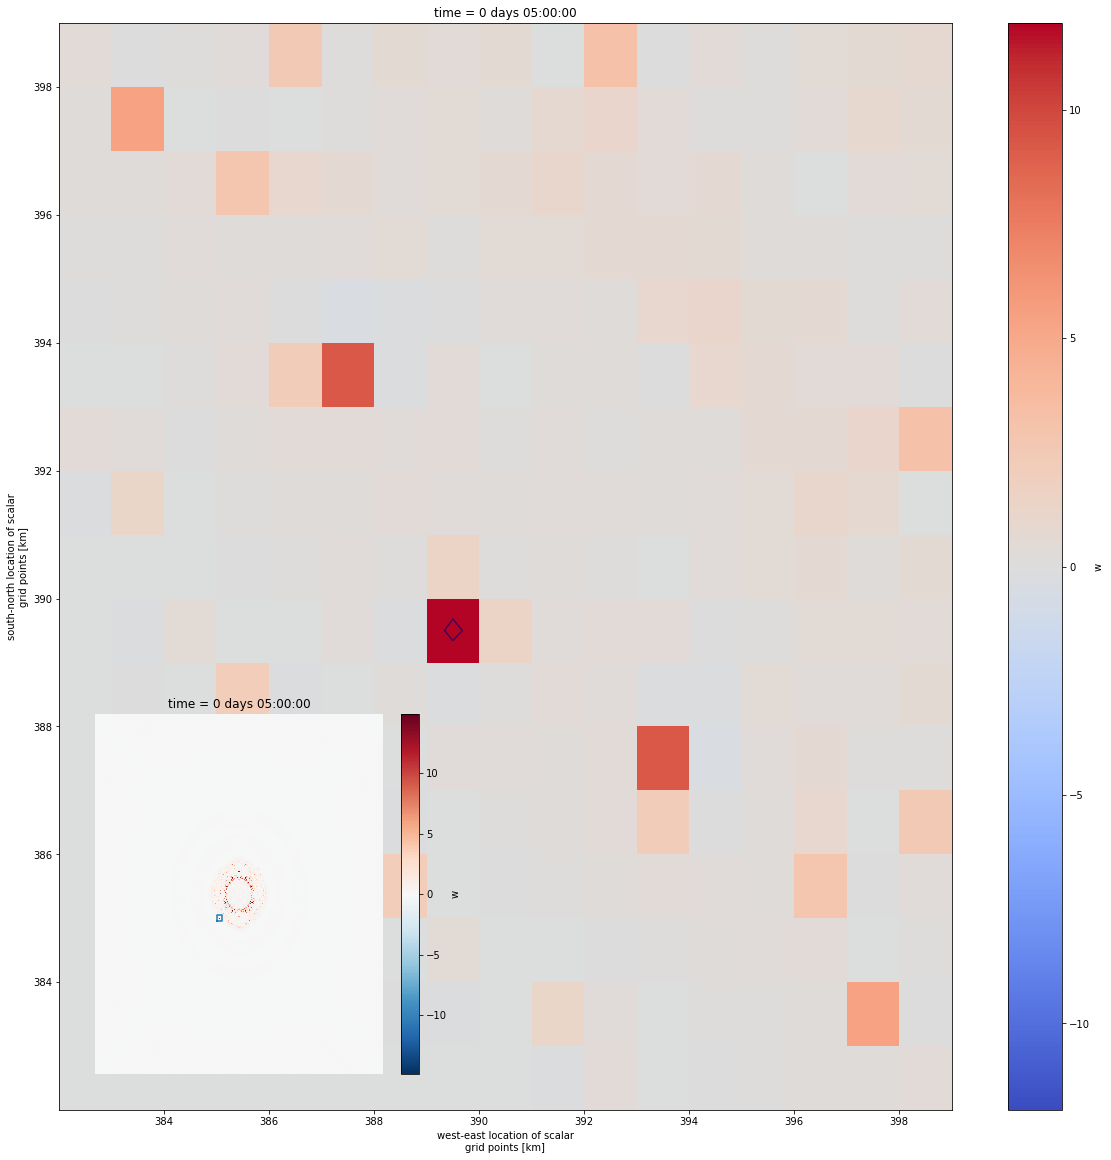

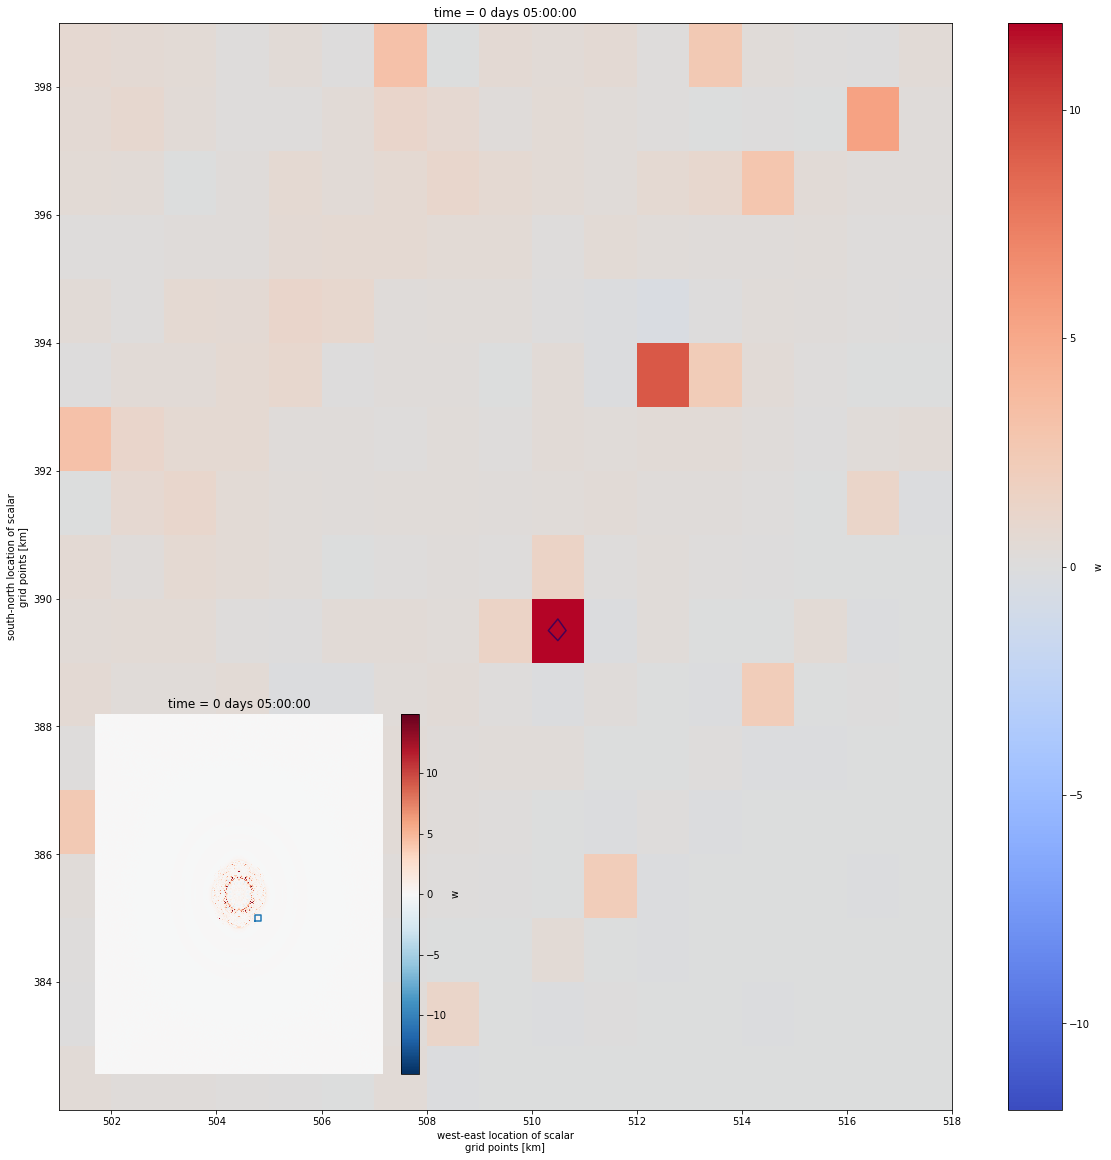

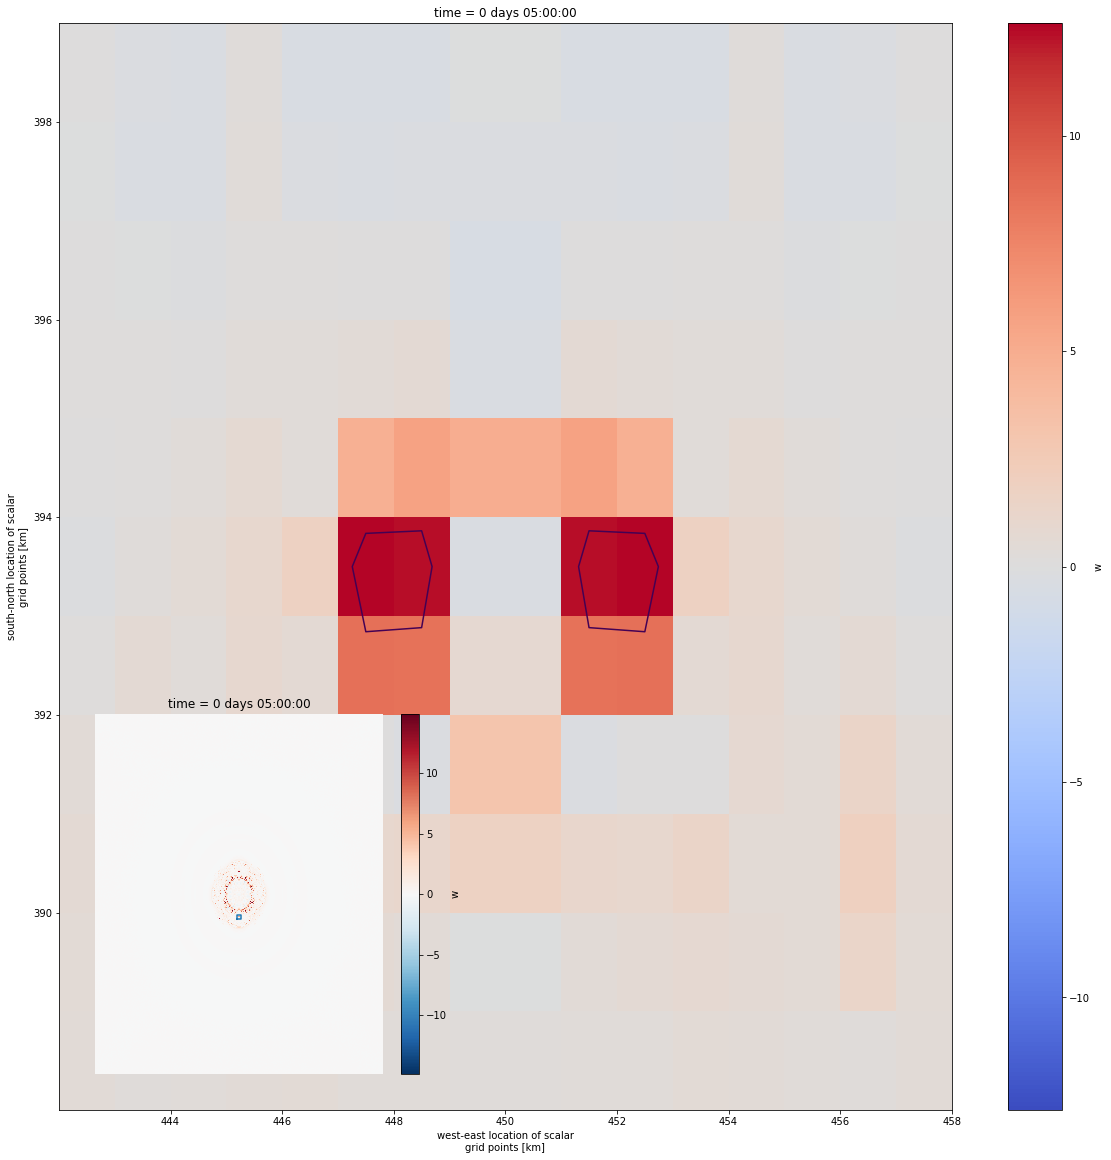

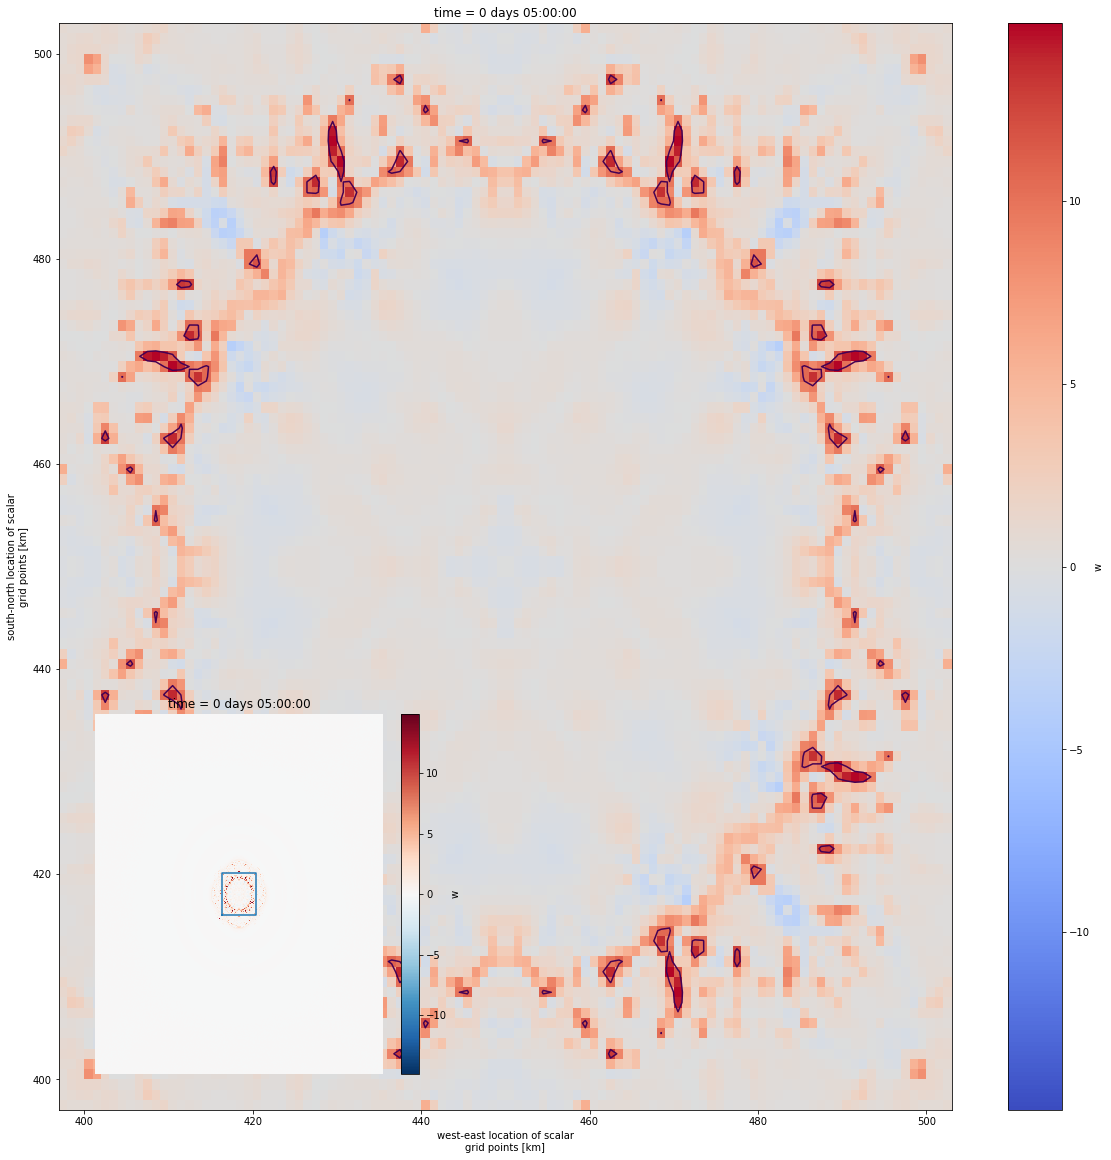

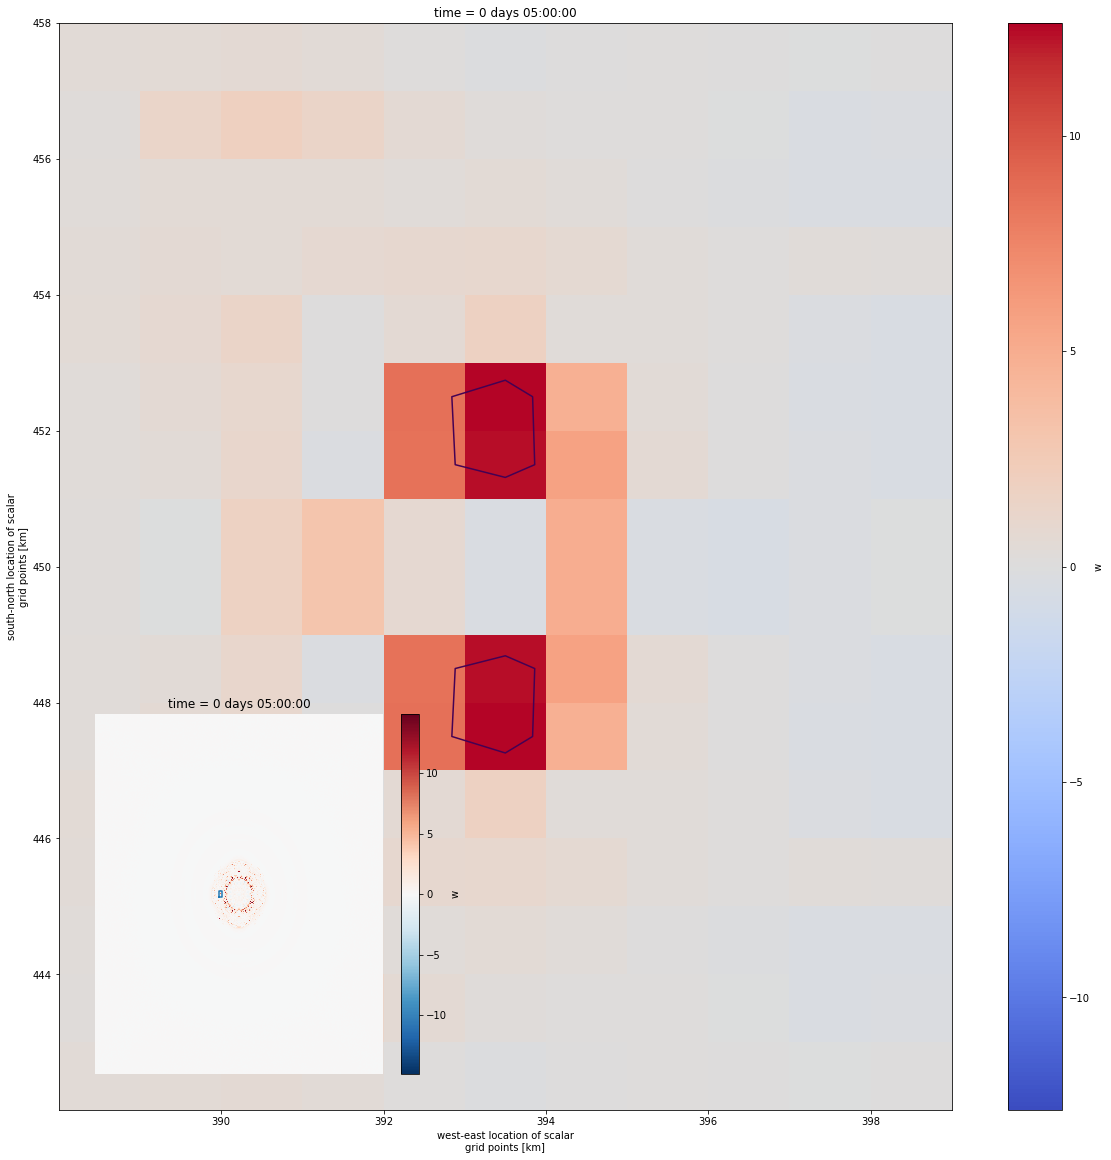

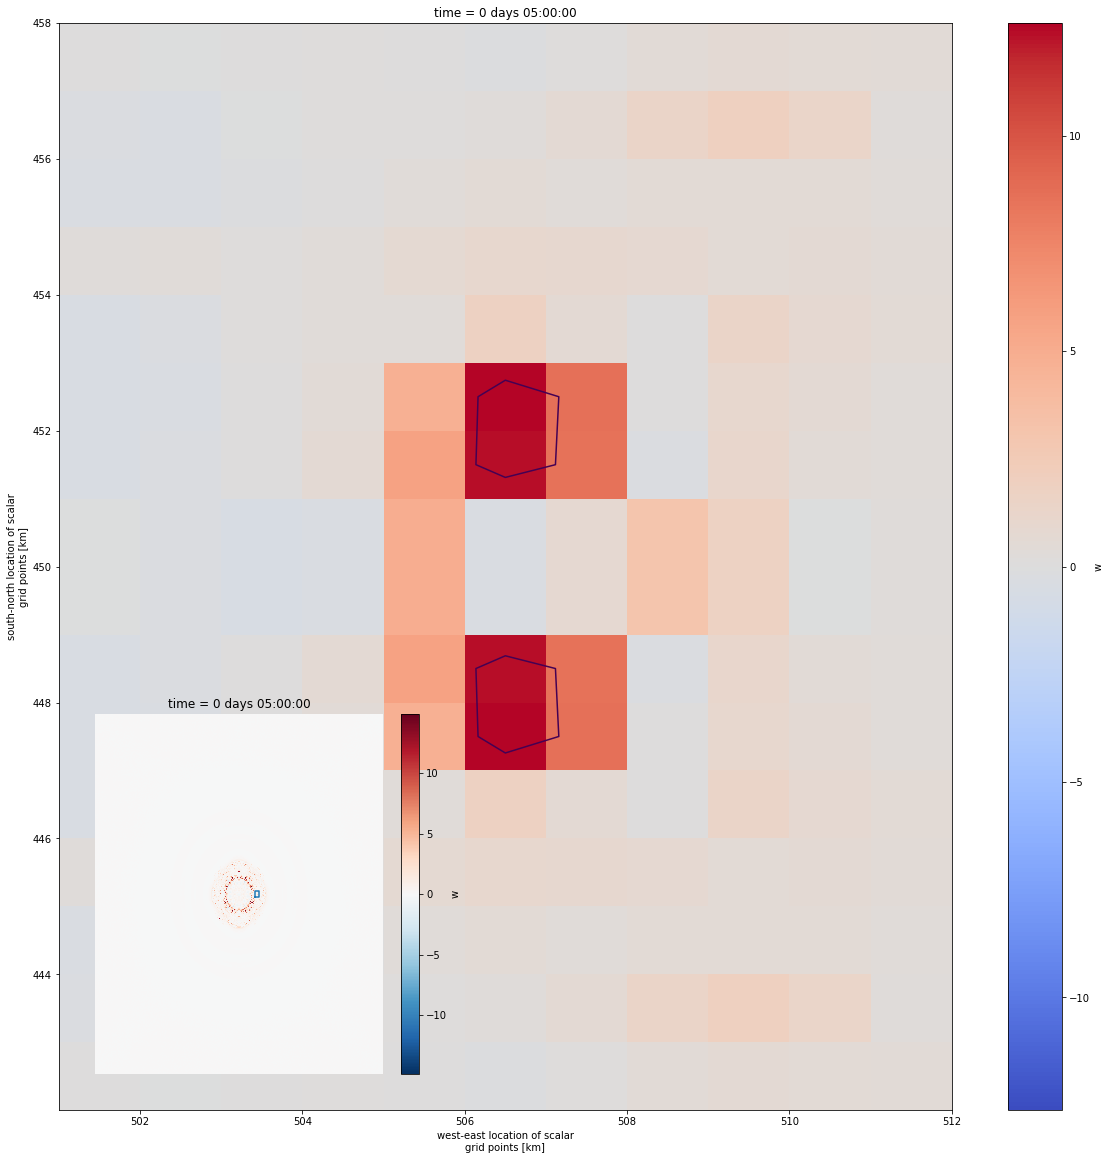

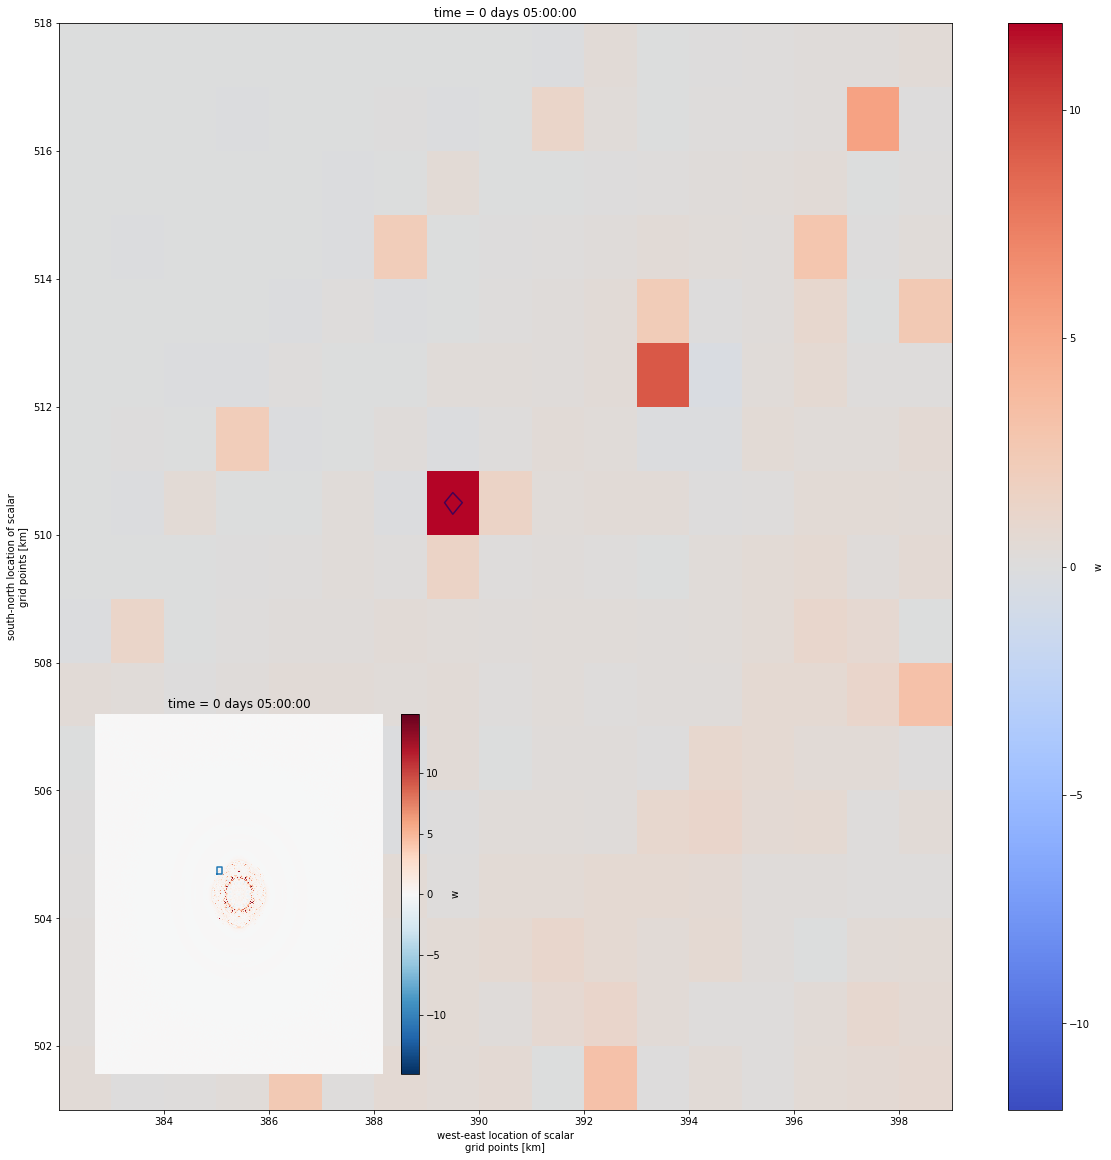

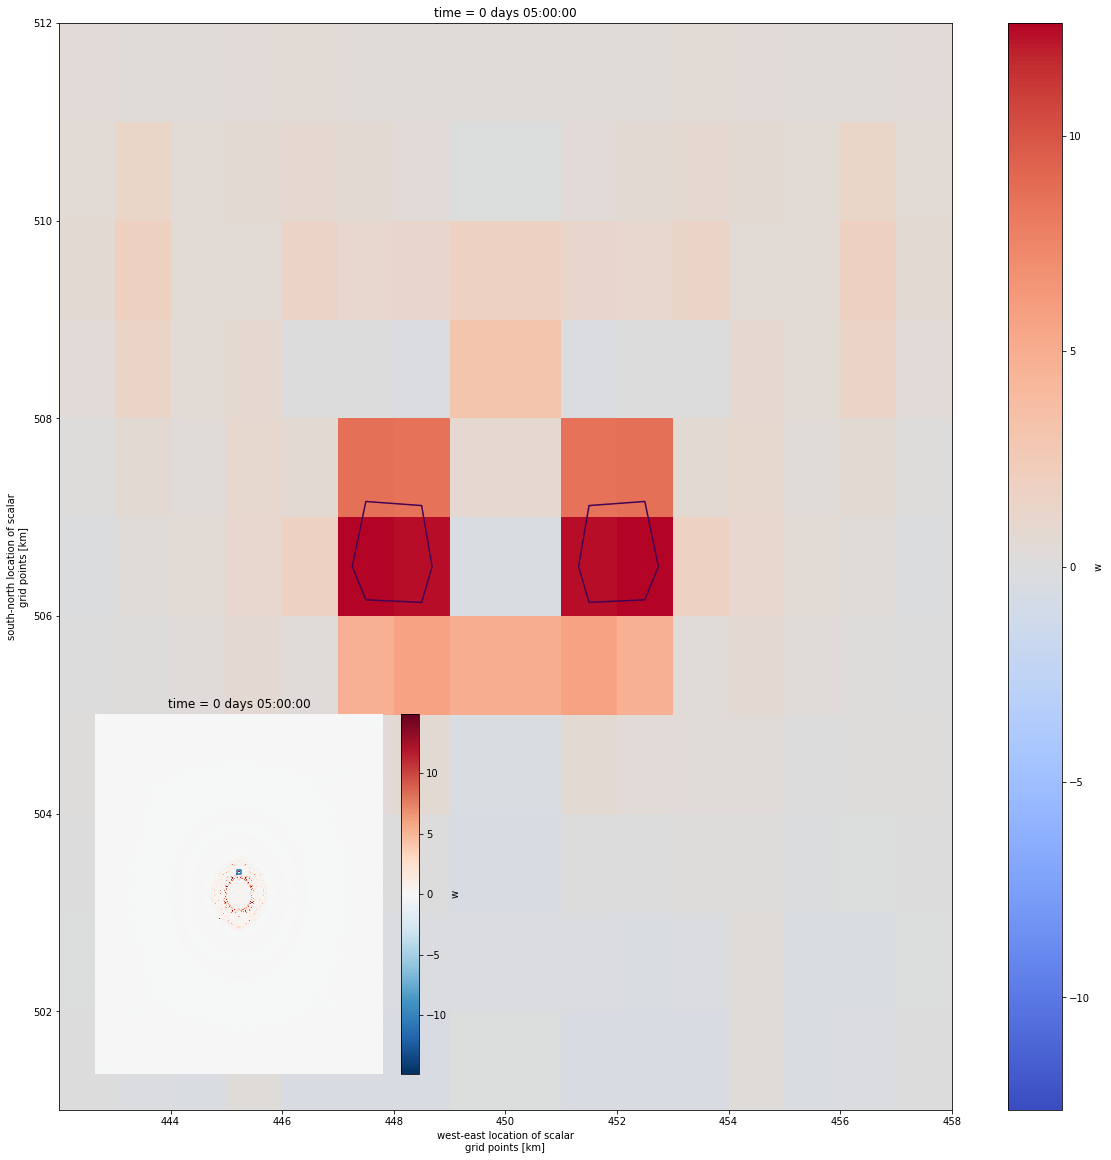

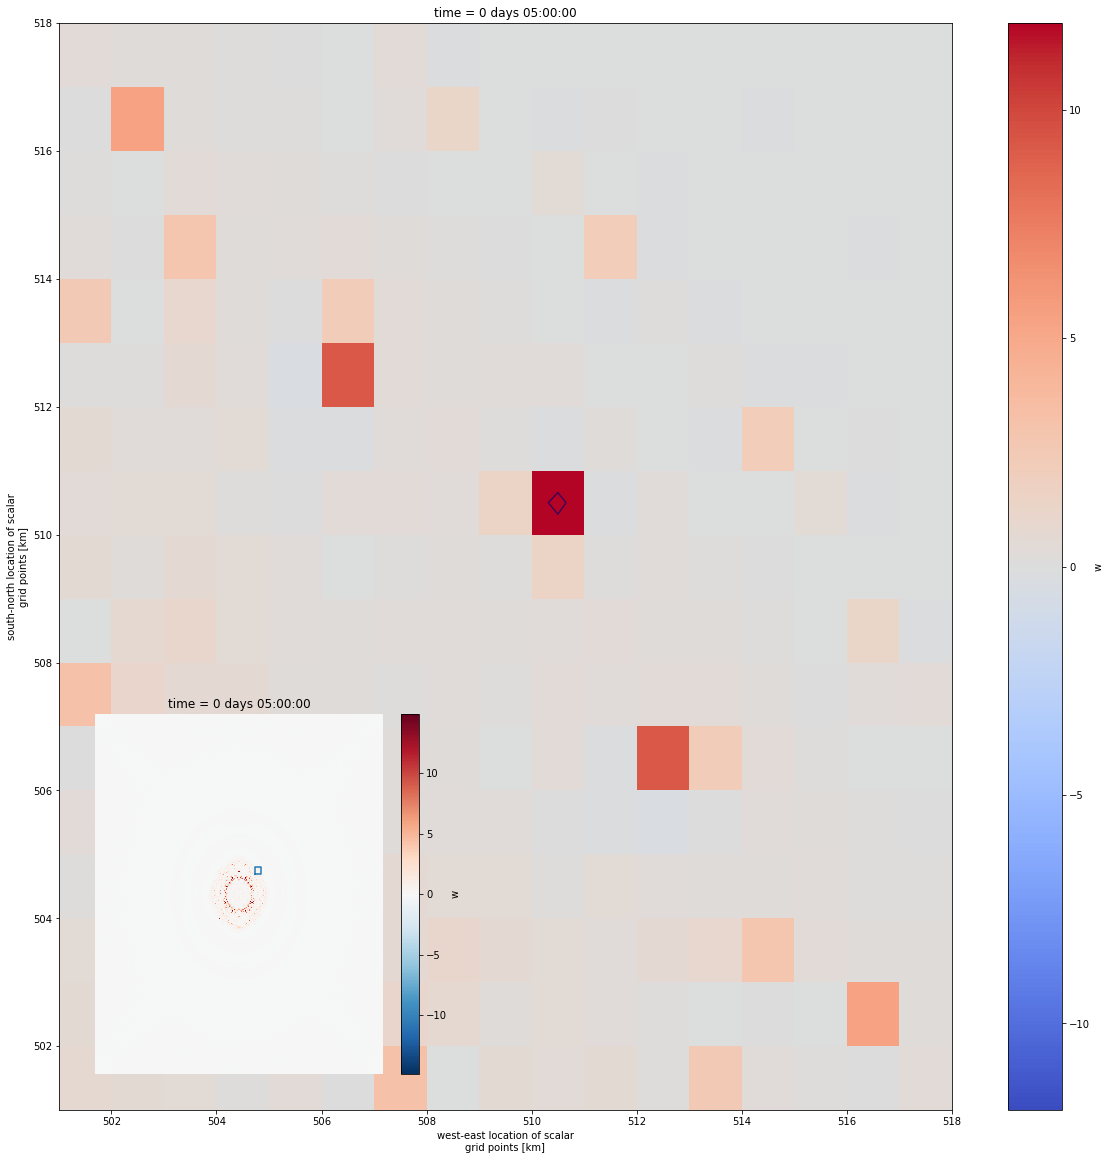

In [125]:
for subset_VV in subsets_VV:
    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    subset_VV.plot(ax=ax, cmap=get_cmap('coolwarm'))
    plt.contour(subset_VV.metpy.x, subset_VV.metpy.y, subset_VV, levels=[10.])
    '''How do I count number of contours in each image?'''
    x_min = subset_VV['xh'].min().item()
    x_max = subset_VV['xh'].max().item()
    y_min = subset_VV['yh'].min().item()
    y_max = subset_VV['yh'].max().item()
    #[0.15, 0.15, 0.25, 0.25]
    ax_inset = fig.add_axes(
        [0.15, 0.15, 0.25, 0.25])
    vertVeloLLComp.plot(ax=ax_inset)
    ax_inset.plot(
        [x_min, x_max, x_max, x_min, x_min],
        [y_min, y_min, y_max, y_max, y_min])
    ax_inset.set_axis_off()
    plt.show()

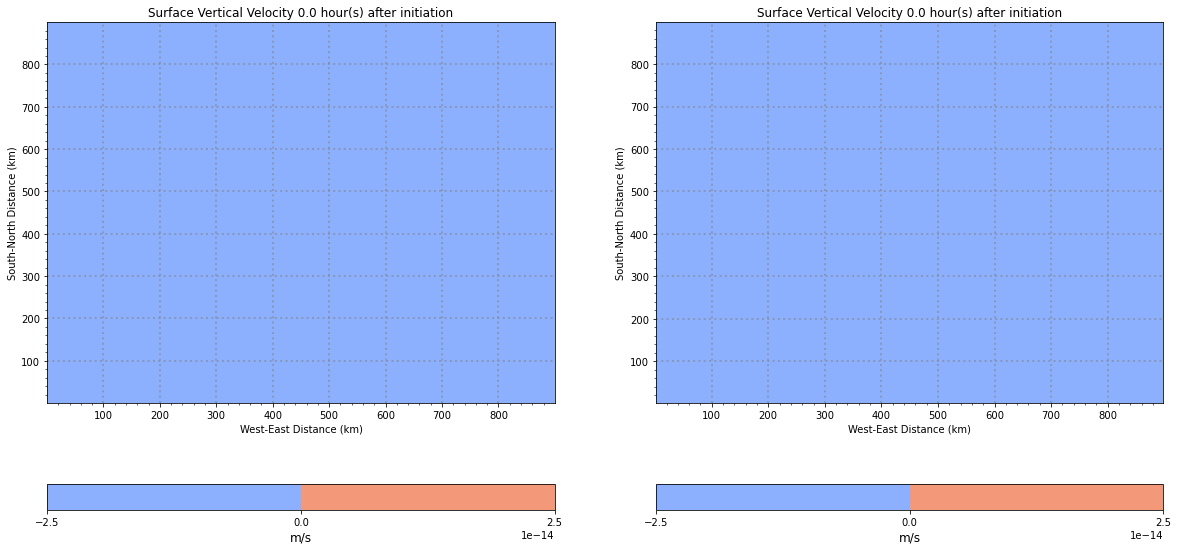

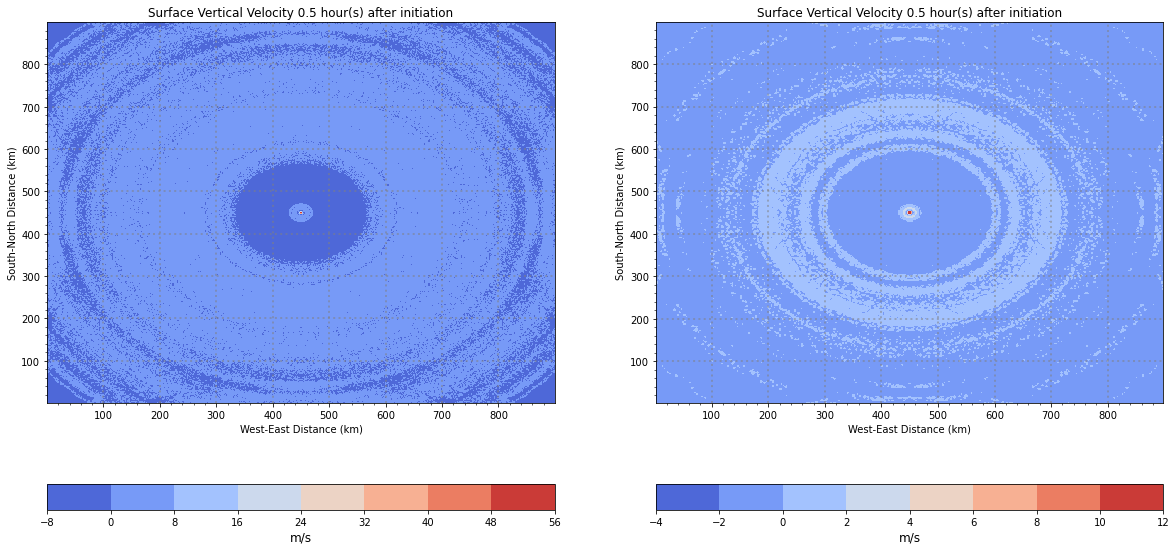

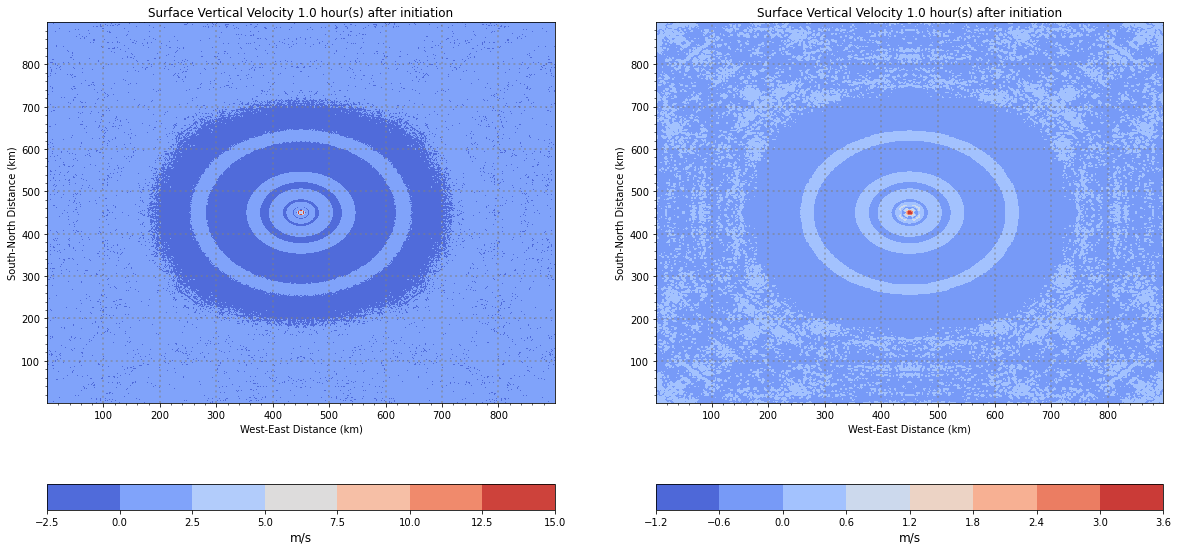

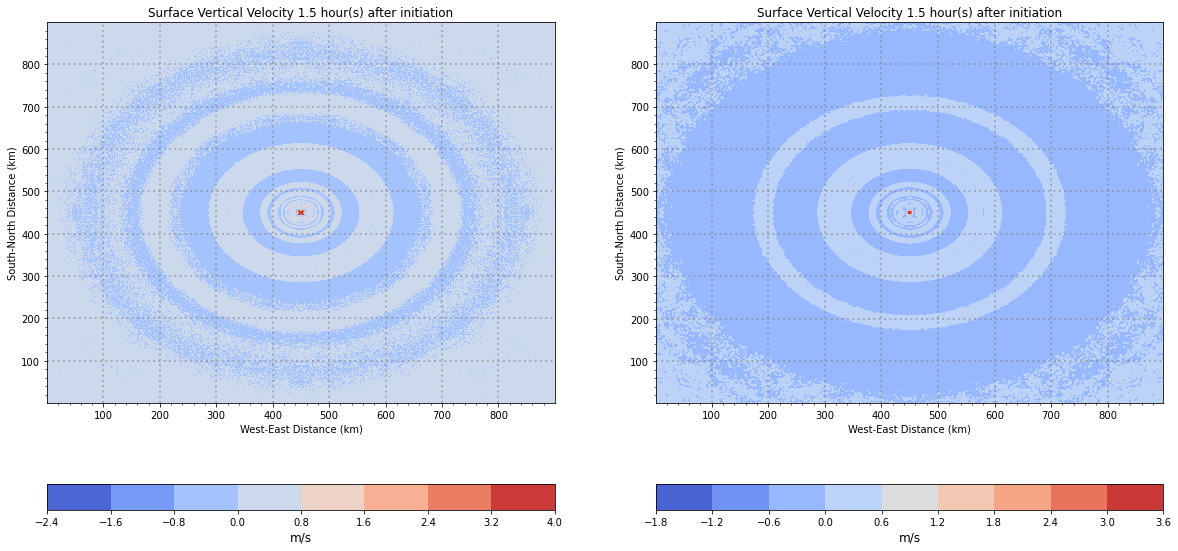

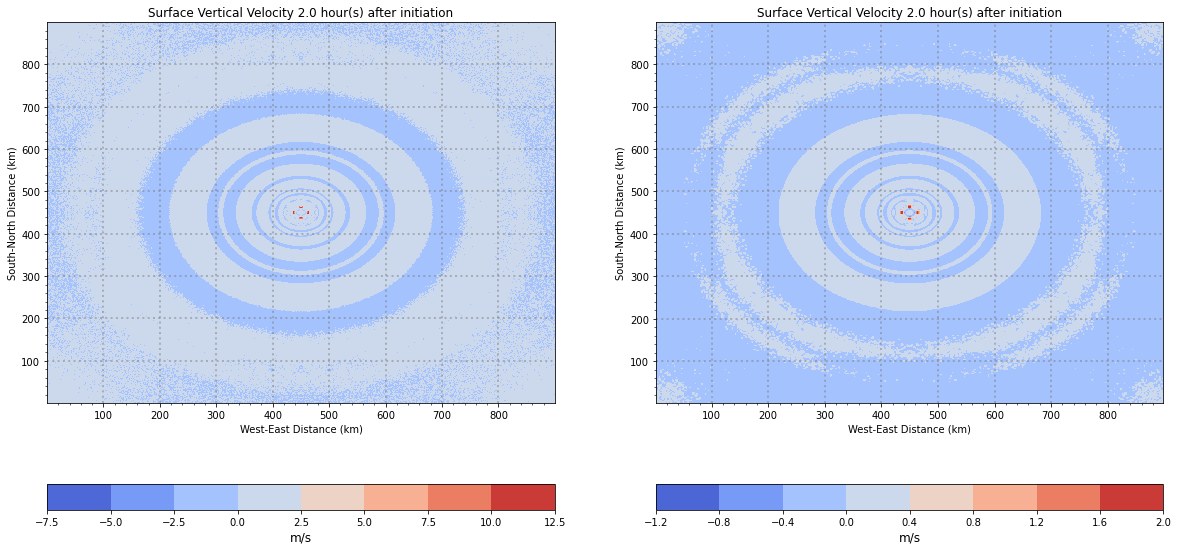

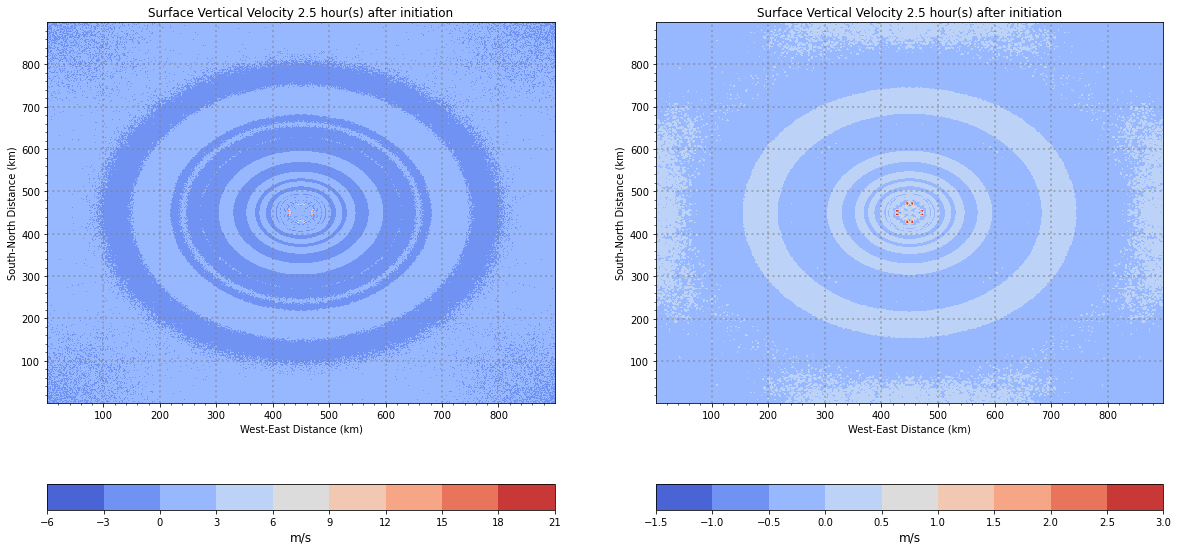

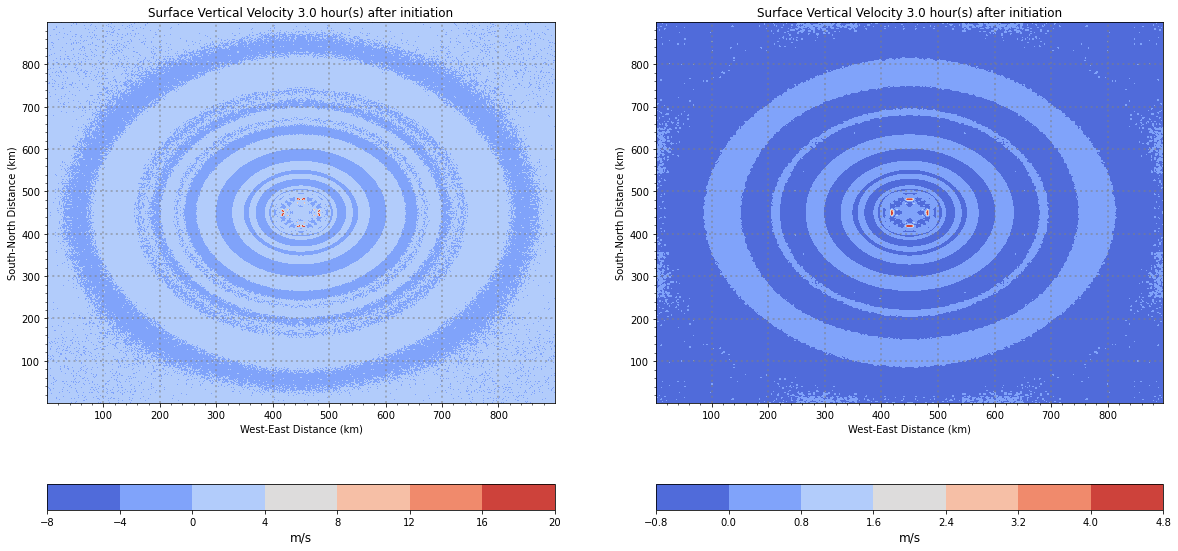

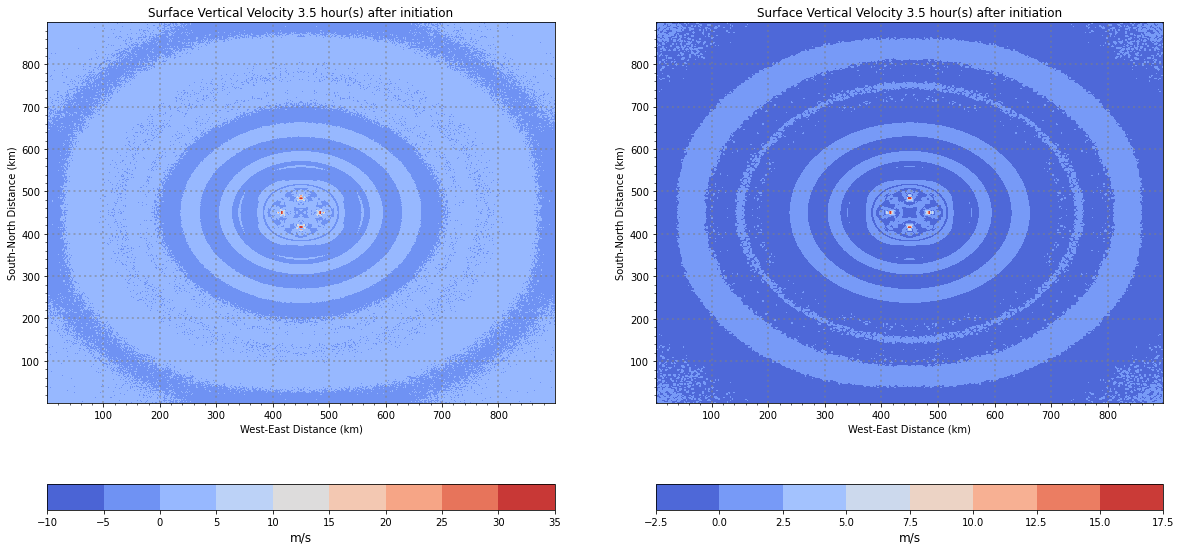

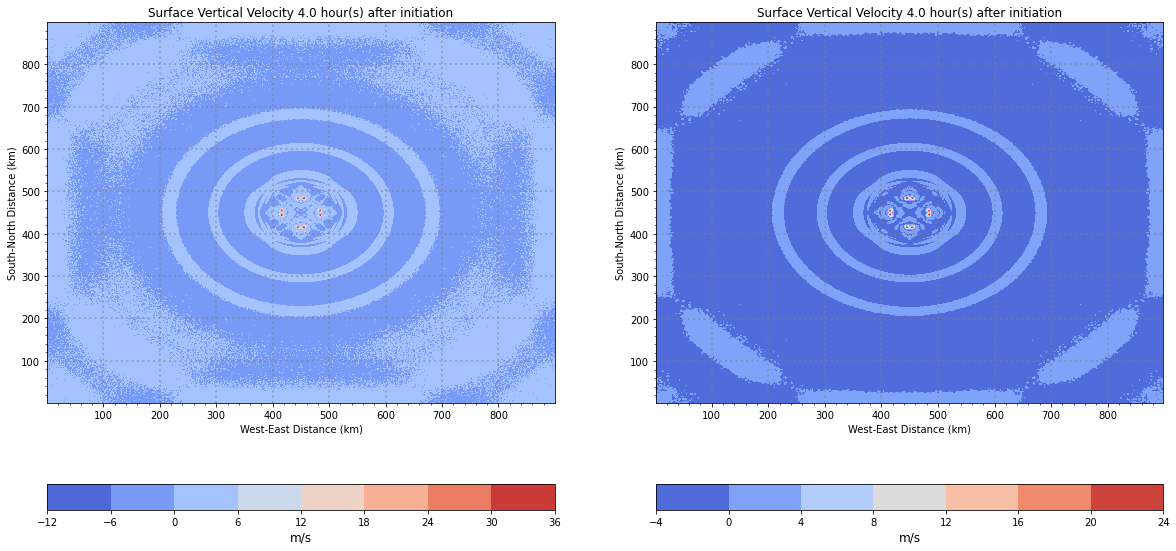

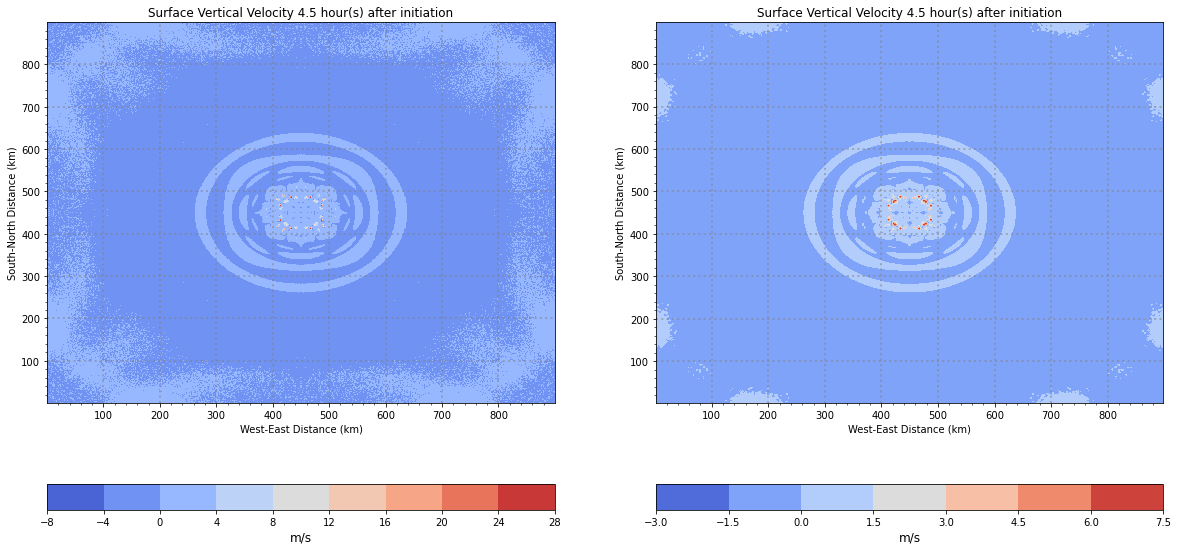

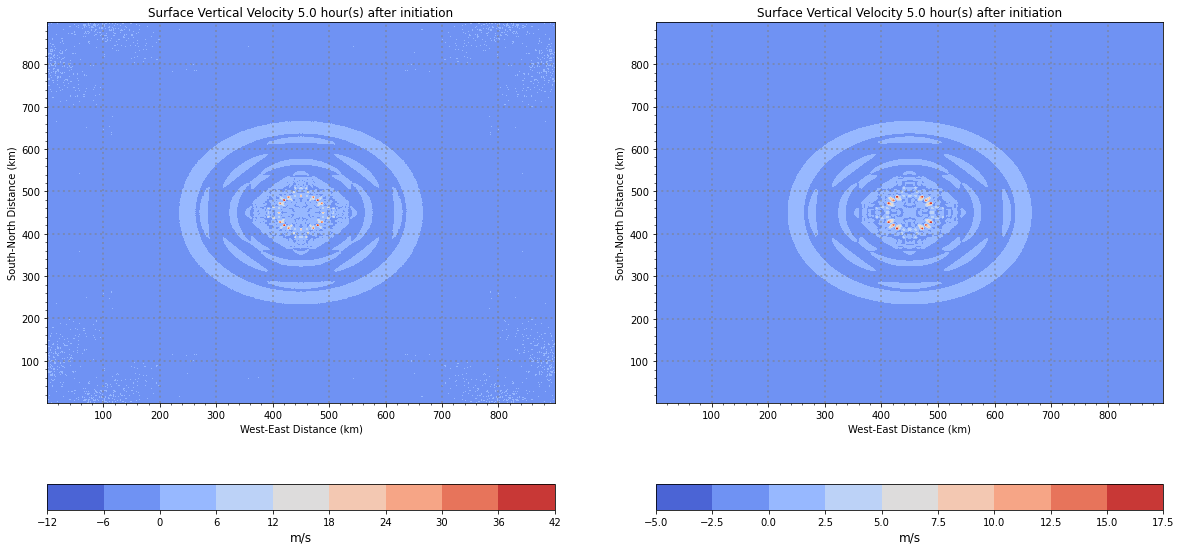

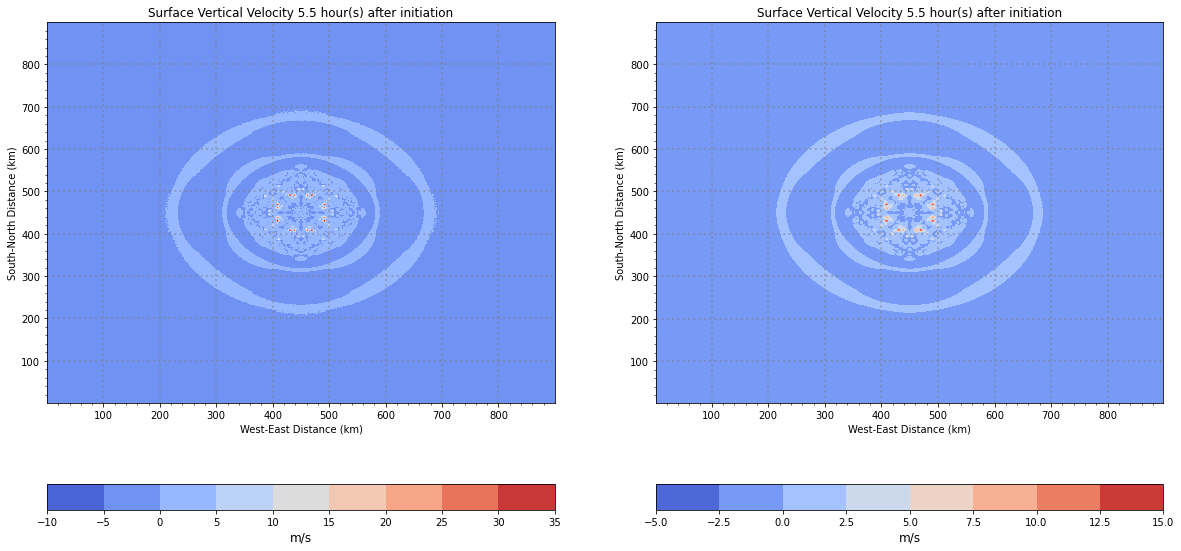

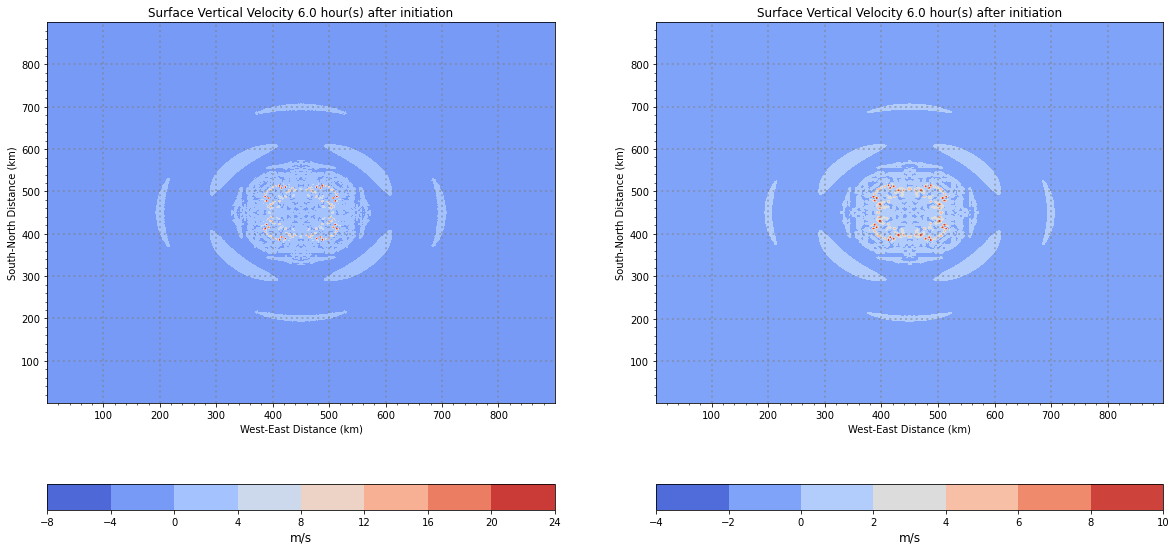

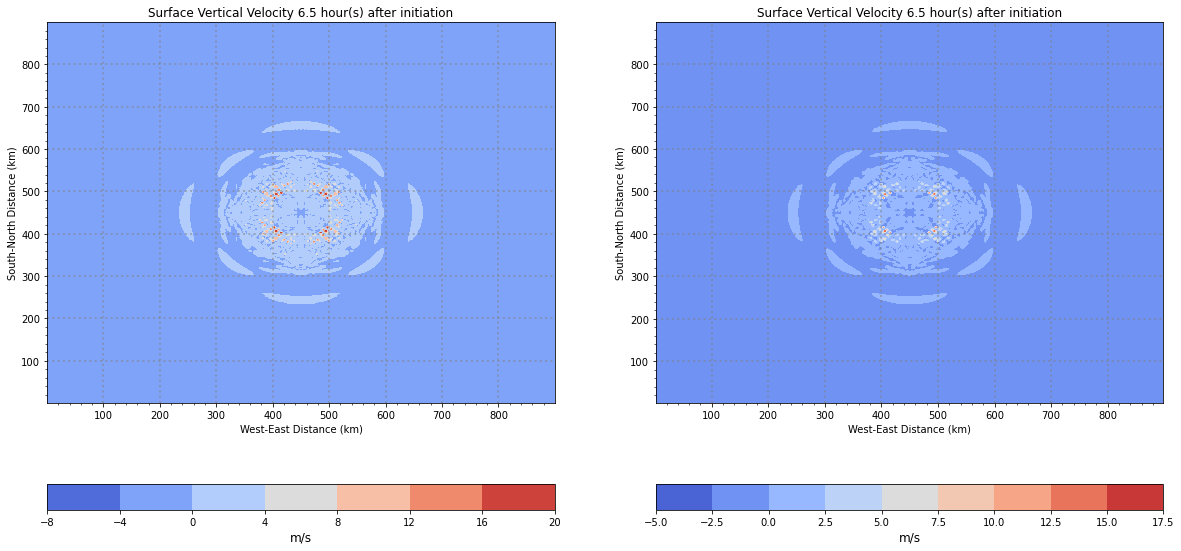

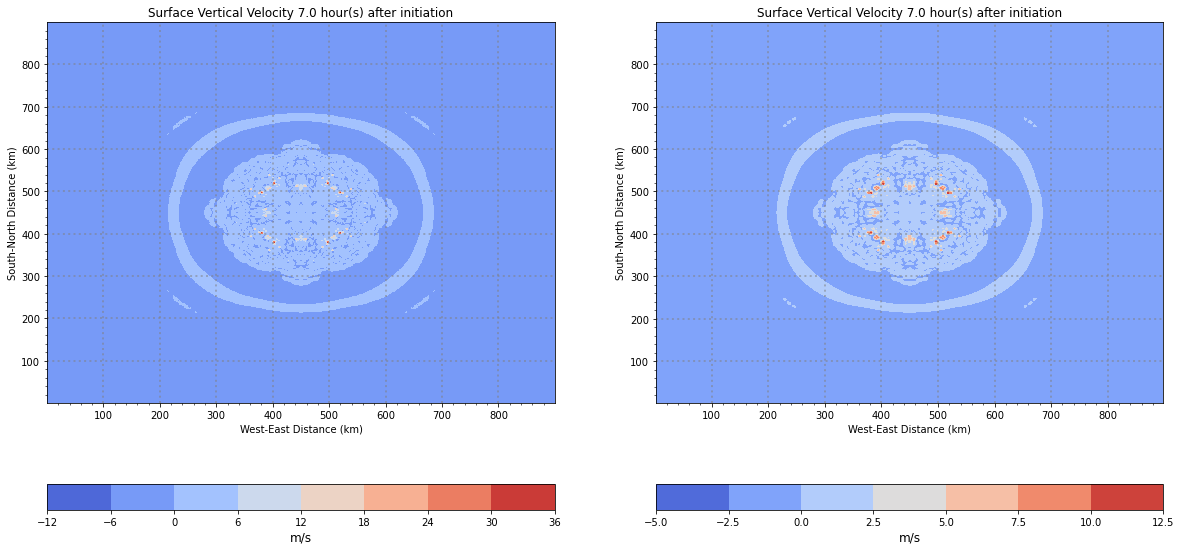

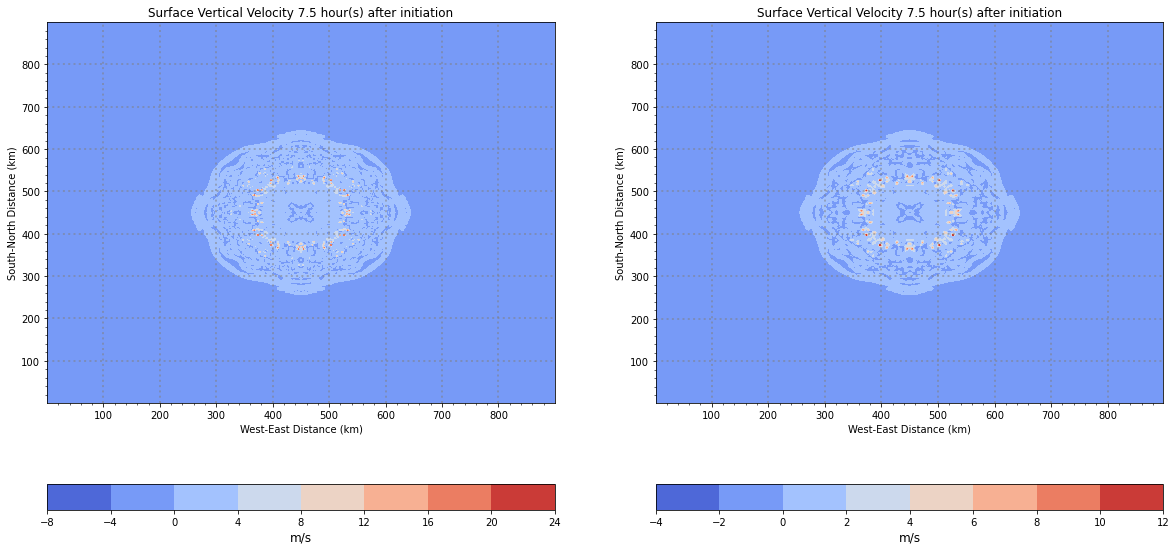

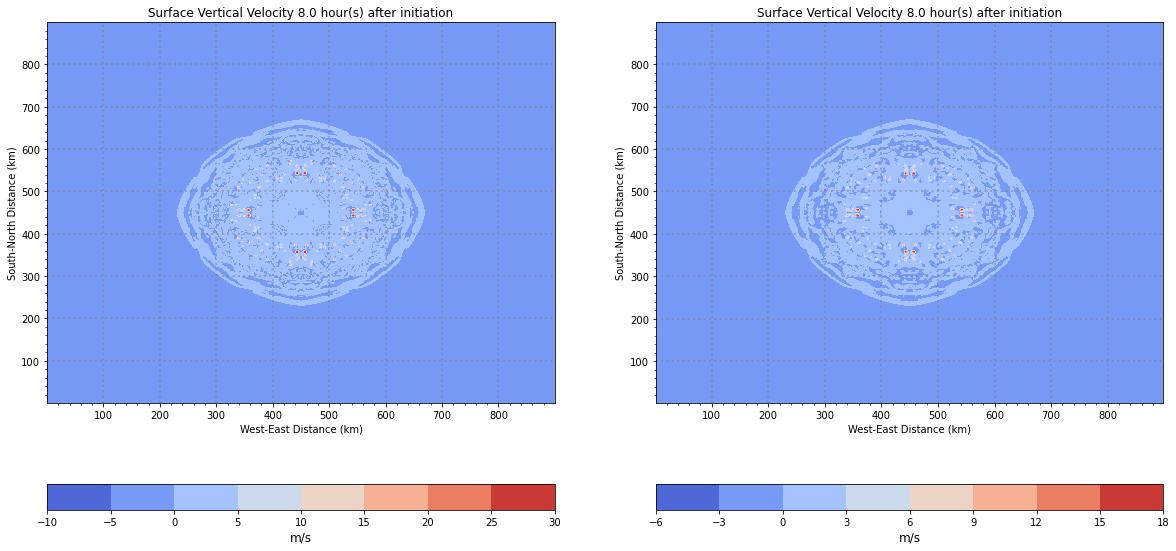

In [39]:
for hour in range(0, 17, 1):

    # Get vertical velocity
    vertVelo = cm1_1km['w']

    # Coarsen data
    coarseVertVelo = vertVelo.coarsen(xh=3, yh=3, boundary='trim').mean()

    # Create figure and axes
    fig = plt.figure(figsize=(20,10))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Plot data
    vvCF = ax1.contourf(vertVelo.metpy.x, vertVelo.metpy.y, vertVelo[hour, 29], cmap='coolwarm')
    vvCB = fig.colorbar(vvCF, ax=ax1, orientation='horizontal')
    vvCB.set_label('m/s', fontsize=12)
    ax1.set_title('Surface Vertical Velocity ' + str(hour * 0.5) + ' hour(s) after initiation')
    ax1.set_xlabel('West-East Distance (km)')
    ax1.set_ylabel('South-North Distance (km)')
    ax1.minorticks_on()
    ax1.grid(which='major', color='gray', alpha=0.5, linestyle='dotted', linewidth=2.)
    
    cvvCF = ax2.contourf(coarseVertVelo.metpy.x, coarseVertVelo.metpy.y, coarseVertVelo[hour, 29], cmap='coolwarm')
    cvvCB = fig.colorbar(cvvCF, ax=ax2, orientation='horizontal')
    cvvCB.set_label('m/s', fontsize=12)
    ax2.set_title('Surface Vertical Velocity ' + str(hour * 0.5) + ' hour(s) after initiation')
    ax2.set_xlabel('West-East Distance (km)')
    ax2.set_ylabel('South-North Distance (km)')
    ax2.minorticks_on()
    ax2.grid(which='major', color='gray', alpha=0.5, linestyle='dotted', linewidth=2.)

In [35]:
coarseVertVelo.where(coarseVertVelo==coarseVertVelo.max(), drop=True).squeeze()

<xarray.DataArray 'w' (yh: 2, xh: 4)>
array([[23.692394,       nan,       nan, 23.692394],
       [      nan, 23.692394, 23.692394,       nan]], dtype=float32)
Coordinates:
    time     timedelta64[ns] 04:00:00
  * xh       (xh) float32 415.5 445.5 454.5 484.5
  * yh       (yh) float32 454.5 484.5
    zf       float32 9.0
Attributes:
    long_name:  vertical velocity
    units:      m/s

/tmp/ipykernel_2127841/2128381194.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  vvContour = ax1.contour(vertVeloLLComp.metpy.x, vertVeloLLComp.metpy.y, vertVeloLLComp, levels=[10.], colors='k', linewidth=1.0)


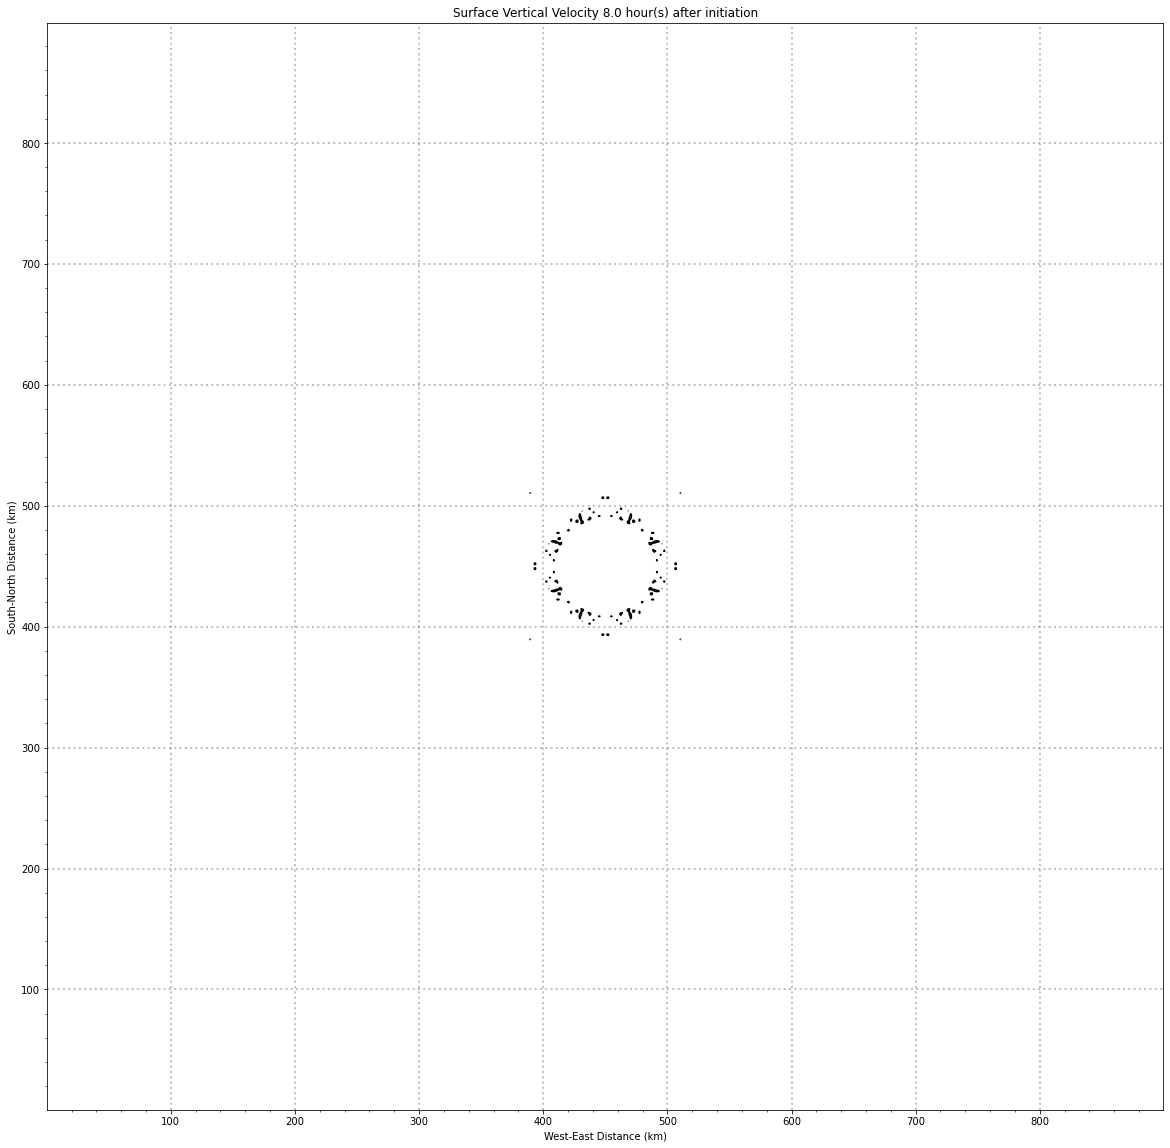

In [92]:
vertVelo = cm1_1km['w']
zf = cm1_1km['zf']
#zf

vertVeloLL = vertVelo[10, 11:18, :, :]
vertVeloLLComp = vertVeloLL.max(dim='zf')
vertVeloLLCoord = vertVeloLL.argmax(dim='zf')
#vertVeloLLCoord


fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(1, 1, 1)

#dbz3km_contour = ax1.contour(dbz3km.metpy.x, dbz3km.metpy.y, dbz3km[hour, 0], levels=[40.], colors='k', linewidth=1.0)
vvContour = ax1.contour(vertVeloLLComp.metpy.x, vertVeloLLComp.metpy.y, vertVeloLLComp, levels=[10.], colors='k', linewidth=1.0)
ax1.set_title('Surface Vertical Velocity ' + str(hour * 0.5) + ' hour(s) after initiation')
ax1.set_xlabel('West-East Distance (km)')
ax1.set_ylabel('South-North Distance (km)')
ax1.minorticks_on()
ax1.grid(which='major', color='gray', alpha=0.5, linestyle='dotted', linewidth=2.)